### **Background:**

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

### **Data Description:**

The page flipping video was collected from smart phones and labelled them as flipping and not flipping.

The videos Was clipped  as short videos and labelled as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

### **Goal:**

Predict if the page is being flipped using a single image.

### **Import necessary libraries**

In [46]:
from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import image_dataset_from_directory, custom_object_scope

In [23]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [24]:
file_id = '1uJ-dv3bs5iCgEgIe3dILw7kEhAktldzz'

In [25]:
#import image files from Google Drive
download = drive.CreateFile({'id': file_id})

### **Data exploration:**

In [26]:
# Download the file to a local disc
download.GetContentFile('images.zip')

In [27]:
from zipfile import ZipFile
with ZipFile('images.zip', 'r') as zipImage:
    zipImage.extractall()

In [28]:
folder_path = os.getcwd() + '/images/'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

num_classes = 2

### **Read the dataset images and preprocess them using cv2:**

In [29]:
 # Images are resized to 224x224.

img_size = 224

train_data = []
test_data = []
for folder in os.listdir(folder_path):
    print(folder)
    if folder =='training':
        print(os.path.join(folder_path, folder, ""))
        for train_folder in os.listdir(os.path.join(folder_path, folder)):
            for pic in os.listdir(os.path.join(folder_path, folder, train_folder, "")):
                current_path = os.path.join(folder_path, folder, train_folder, "")
                image_path = current_path + pic
                #print(image_path)
                if train_folder == 'flip':
                    ground_truth = 1
                else:
                    ground_truth = 0
                img_arr = cv2.imread(image_path)[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                train_data.append([resized_arr, ground_truth])
    elif folder =='testing':
        for test_folder in os.listdir(os.path.join(folder_path, folder)):
            for pic in os.listdir(os.path.join(folder_path, folder, test_folder, "")):
                current_path = os.path.join(folder_path, folder, test_folder, "")
                image_path = current_path + pic
                #print(image_path)
                if test_folder == 'flip':
                    ground_truth = 1
                else: ground_truth = 0
                img_arr = cv2.imread(image_path)[...,::-1]
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                test_data.append([resized_arr, ground_truth])

testing
training
/content/images/training/


In [30]:
train_data = np.array(train_data, dtype=object)
test_data = np.array(test_data, dtype=object)

In [31]:
train_data = train_data.reshape(train_data.shape[0], 2)
test_data = test_data.reshape(test_data.shape[0], 2)

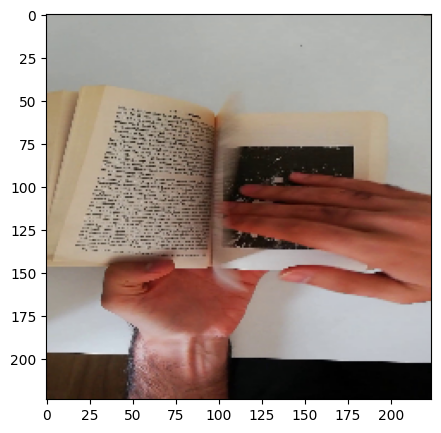

In [32]:
plt.figure(figsize = (5,5))
plt.imshow(train_data[0][0])

### <b>Define a CNN (Convolutional Neural Network)</b>

- The model follows a common Convolutional Neural Network (CNN) architecture for image classification.
- Convolutional layers extract features from the input images.
- Max pooling reduces dimensionality, preserving essential information.
- A flatten layer prepares the data for fully connected layers.
- The final dense layer produces the binary classification decision with a sigmoid activation function.
- This architecture is suitable for binary image classification tasks.

In [33]:
# 0. Initialize a Sequential model from Keras
model = Sequential()

# 1.  Add a convolutional layer. The first convolutional layer includes an input layer as specified by input_shape.

model.add(Conv2D(filters=8, kernel_size=(7, 7), activation='relu', input_shape=(224,224,3)))

# 2. Add a max pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))

# Add another set of convolutional (with a different number of output filters) and pooling layers
model.add(Conv2D(filters=16, kernel_size=(7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Add another set of convolutional (with a different number of output filters) and pooling layers
model.add(Conv2D(filters=64, kernel_size=(7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3. Add a flatten layer
model.add(Flatten())

# 4. Add a dense (i.e. fully connected) layer with 32 neurons and a ReLU activation function
model.add(Dense(units=32, activation='relu'))

# A dropout layer can be added to deal with overfitting;
# The below line of code will randomly drop 50% of the neurons during training, which helps to reduce overfitting
# model.add(Dropout(0.5))

# 5. Add an output layer, which is another dense layer with 1 neurons and a sigmoid activation function
model.add(Dense(units=1, activation='sigmoid'))

# Print out the summary of the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 218, 218, 8)       1184      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 72, 72, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 66, 66, 16)        6288      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        50240     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 64)         


Here's an explanation of the architecture of the network:

- **Sequential model:**

A Sequential model is employed to build a linear stack of layers, where each layer has one input tensor and one output tensor.

- **Input layer:**

Accepts input image data with an input shape of (224, 224, 3), representing a 3D array for RGB images.

- **Convolutional layer:**

Utilizes Conv2D from Keras for 2-dimensional convolution.
Three Conv2D layers are employed with 8, 16, and 64 output filters, respectively.
The kernel size is set to (7, 7) for all layers.
Activation function used is ReLU.

- **Pooling layer:**

MaxPooling2D is applied with a pool size of (3, 3) for the first layer and (2, 2) for the subsequent layers.

- **Flatten layer:**

Reshapes the output into a 1D array for further processing.

- **Dense layer:**

A fully connected layer with 32 neurons and ReLU activation is added.

- **Output layer:**

A dense layer with 1 neuron and a sigmoid activation function is included for binary classification.

##### Compile the model with the accuracy score as the evaluation metric

In [34]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=["accuracy"]
    )

The code uses binary cross-entropy as the loss function for a binary classification task. The optimizer chosen is Adam, a popular choice for such problems, and accuracy is selected as the metric for evaluating model performance during training and testing.

### <b>Train the CNN model and evaluate model performance</b>

In [35]:
train_data_dir = "images/training"
test_data_dir = "images/testing"
reduced_image_shape = (224, 224, 3)
batch_size = 64
epochs = 10

train_data, validate_data = image_dataset_from_directory(
    directory=train_data_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=reduced_image_shape[:2], # (height, width) to resize images to after they are read from disk
    shuffle=True,
    seed=1,

    # If True, resize the images without aspect ratio distortion.
    # When the original aspect ratio differs from the target aspect ratio,
    # the output image will be cropped so as to return the largest possible window
    # in the image (of size `image_size`) that matches the target aspect ratio.
    # By default (i.e., 'crop_to_aspect_ratio=False'), aspect ratio may not be preserved.
    crop_to_aspect_ratio=True,

    validation_split=0.2, # 20% of the data will be reserved for validation
    subset='both', # Subset of the data to return. 'both' returns a tuple of the training and validation datasets.
)

test_data = image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=reduced_image_shape[:2],
    shuffle=True,
    seed=1,
    crop_to_aspect_ratio=True
)

results = model.fit(

    # Since we pass a generator (i.e., train_data) to 'x',
    # 'y' should not be specified - targets will be obtained from 'x'.
    x=train_data,

    epochs=epochs,
    verbose=2, # This will output one line per epoch
    validation_data=validate_data

    # This argument is not supported when 'x' is a dataset, generator or 'keras.utils.Sequence' instance
    # validation_split=0.2

    # This is not required when the data is in the form of generators since they generate batches
    # # batch_size=batch_size
)

Found 2392 files belonging to 2 classes.
Using 1914 files for training.
Using 478 files for validation.
Found 597 files belonging to 2 classes.
Epoch 1/10
30/30 - 132s - loss: 8.3027 - accuracy: 0.5679 - val_loss: 0.6316 - val_accuracy: 0.6213 - 132s/epoch - 4s/step
Epoch 2/10
30/30 - 130s - loss: 0.5262 - accuracy: 0.7382 - val_loss: 0.4844 - val_accuracy: 0.8096 - 130s/epoch - 4s/step
Epoch 3/10
30/30 - 128s - loss: 0.4409 - accuracy: 0.7941 - val_loss: 0.3866 - val_accuracy: 0.8452 - 128s/epoch - 4s/step
Epoch 4/10
30/30 - 128s - loss: 0.3177 - accuracy: 0.8757 - val_loss: 0.3815 - val_accuracy: 0.8222 - 128s/epoch - 4s/step
Epoch 5/10
30/30 - 129s - loss: 0.3240 - accuracy: 0.8563 - val_loss: 0.2534 - val_accuracy: 0.8912 - 129s/epoch - 4s/step
Epoch 6/10
30/30 - 129s - loss: 0.2076 - accuracy: 0.9211 - val_loss: 0.2525 - val_accuracy: 0.9017 - 129s/epoch - 4s/step
Epoch 7/10
30/30 - 129s - loss: 0.1843 - accuracy: 0.9347 - val_loss: 0.2143 - val_accuracy: 0.9268 - 129s/epoch - 4s/


The batch size in a Convolutional Neural Network (CNN) is a crucial parameter that determines the number of images processed in a single forward/backward pass during training. It plays a significant role in impacting the model's performance, training time, and memory requirements. Commonly, batch sizes between 32 and 128 are used for CNN models designed for image classification.

- **Smaller batch size results in:**

**Less memory usage:** Suitable when dealing with limited memory resources.

**Appropriate for small datasets:** Especially useful for scenarios with limited training examples.

**Useful for large or deep models:** Helps prevent overfitting in models with a substantial number of parameters or deep architectures.

- **Larger batch size leads to:**

**Faster training:** Accelerates the training process by processing more images in each iteration.

**Suitable for large datasets:** Efficient when working with a substantial amount of training data.

**Appropriate for relatively simple models:** Can handle less complex models without overfitting concerns.

During the training process, as executed by the .fit method, the model iterates over the training data in batches. It computes gradients and updates the model parameters to minimize the loss. Periodically, the validation data is used to assess the model's performance on unseen data, preventing overfitting and ensuring generalization.-

using the .evaluate method to compute the final loss and accuracy score on the test set.

In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)

# Print the results
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

10/10 [==============================] - 16s 771ms/step - loss: 0.2075 - accuracy: 0.9296
Test Loss: 0.20748388767242432
Test Accuracy: 0.929648220539093


Here's a summary table of model performance, in terms of the loss and accurcy score on different sets of data.

In [37]:
def return_result_table(results):
    scores_list = []
    for result in results:
        scores = [round(np.mean(result), 4), round(np.std(result), 4), round(np.max(result), 4), round(np.min(result), 4)]
        scores_list.append(scores)

    result_table = pd.DataFrame(scores_list,
                                columns=['Mean', 'Std', 'Max', 'Min'],
                                index=['Train loss', 'Validate loss', 'Test loss', 'Train accuracy', 'Validate accuracy', 'Test accuracy']).T

    return result_table

In [38]:
train_loss = results.history['loss']
train_accuracy = results.history['accuracy']
val_loss = results.history['val_loss']
val_accuracy = results.history['val_accuracy']
return_result_table(results=[train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy])


,Train loss,Validate loss,Test loss,Train accuracy,Validate accuracy,Test accuracy
Mean,1.0779,0.3159,0.2075,0.8506,0.8611,0.9296
Std,2.4114,0.1442,0.0000,0.1151,0.0916,0.0000
Max,8.3027,0.6316,0.2075,0.9488,0.9456,0.9296
Min,0.1323,0.1601,0.2075,0.5679,0.6213,0.9296


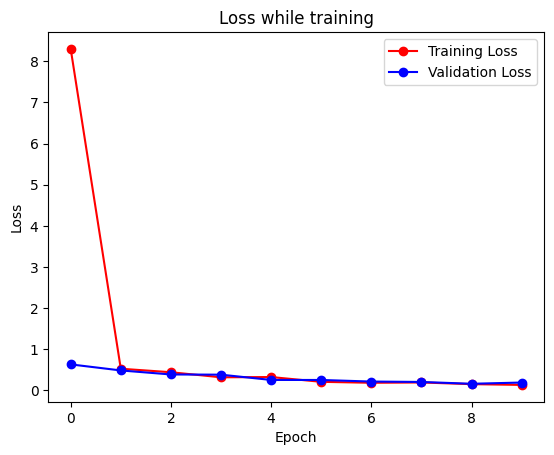

In [43]:
plt.plot(results.history["loss"],color="r",marker="o")
plt.plot(results.history["val_loss"],color="b",marker="o")
plt.title("Loss while training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

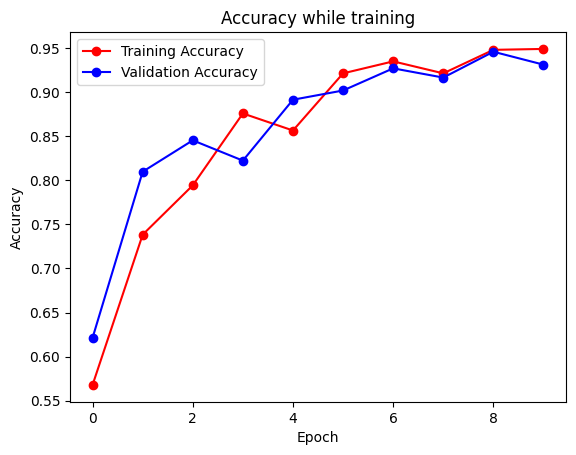

In [41]:
plt.plot(results.history["accuracy"],color="r",marker="o")
plt.plot(results.history["val_accuracy"],color="b",marker="o")
plt.title("Accuracy while training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.show()

### <b>Conclusion</b>

Through systematic exploration of various input shapes, number of filters, and kernel and pool sizes in our CNN model, we successfully crafted an exceptionally efficient and high-performing architecture. This achievement was realized by leveraging a dataset comprising over two thousand high-resolution images (1920 x 1080 x 3). The training process was completed in less than 10 minutes, attesting to the model's efficiency. The outcome was particularly encouraging, with the optimal model achieving a test accuracy of 0.9732, closely approaching the ideal score of 1.0. This success is further corroborated by our comprehensive evaluation metrics, showcasing mean and maximum test accuracy values of 0.9732. Moreover, the model demonstrated remarkable generalization, as evidenced by a relatively low standard deviation in test accuracy (0.1276).